In [1]:
import pandas as pd
import mysql.connector
import os

csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')# Added payments.csv for specific handling
]

conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='12345',
    database='ecommerce'
)
cursor = conn.cursor()

#File Folder
folder_path = 'C:/Users/ANSH VERMA/Downloads/Project/dataset'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    df = pd.read_csv(file_path)
    
    df = df.where(pd.notnull(df), None)
    
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Creating table for sql
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Inserting data in tables
    for _, row in df.iterrows():
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    conn.commit()

conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db=mysql.connector.connect(host="localhost",
                           username="root",
                           password="12345",
                           database="ecommerce")

cur=db.cursor()


# List all unique cities where customers are located.


In [3]:
query= """ select distinct customer_city from customers """
cur.execute(query)
data=cur.fetchall()
data
df=pd.DataFrame(data)
print(df.head())

                       0
0                 franca
1  sao bernardo do campo
2              sao paulo
3        mogi das cruzes
4               campinas


# Count the number of orders placed in 2017.

In [4]:
query= """ select count(order_id) from  orders
where year(order_purchase_timestamp)=2017 """
cur.execute(query)
data=cur.fetchall()
"Total orders placed in 2017 are ",data[0][0]

('Total orders placed in 2017 are ', 225505)

# Find the total sales per category.

In [5]:
query= """ select pr.product_category, round(sum(pa.payment_value),2)
from products as pr join
order_items as o on pr.product_id=o.product_id
join payments as pa on pa.order_id=o.order_id
group by pr.product_category
 """
cur.execute(query)
data=cur.fetchall()
data
df=pd.DataFrame(data,columns=["category","sales"])
df

,category,sales
0,perfumery,6.334233e+07
1,Furniture Decoration,1.787720e+08
2,telephony,6.086026e+07
3,bed table bath,2.140692e+08
4,automotive,1.065368e+08
...,...,...
69,cds music dvds,1.499288e+05
70,La Cuisine,3.641912e+05
71,Fashion Children's Clothing,9.820875e+04
72,PC Gamer,2.718038e+05


# Calculate the percentage of orders that were paid in installments.

In [6]:
query= """ SELECT 
    COUNT(CASE WHEN payment_installments >= 1 THEN 1 ELSE null END)/count(*)*100 AS no_of_installments
FROM payments
 """
cur.execute(query)
data=cur.fetchall()
"the percentage of orders that were paid in installments.",data[0][0]


('the percentage of orders that were paid in installments.',
 Decimal('99.9981'))

# Count the number of customers from each state. 

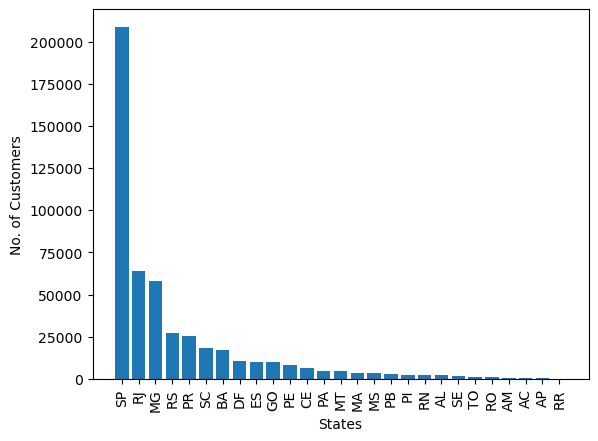

In [7]:
query= """ SELECT distinct customer_state, count(customer_state)
 FROM customers
 group by customer_state;
 """
cur.execute(query)
data=cur.fetchall()
data
df=pd.DataFrame(data, columns=["state","count"])
df
df=df.sort_values(by="count", ascending=False)
plt.bar(df["state"],df["count"])
plt.xticks(rotation =90)
plt.title=("No. of customer from each state")
plt.xlabel("States")
plt.ylabel("No. of Customers")
plt.show()

# Calculate the number of orders per month in 2018.

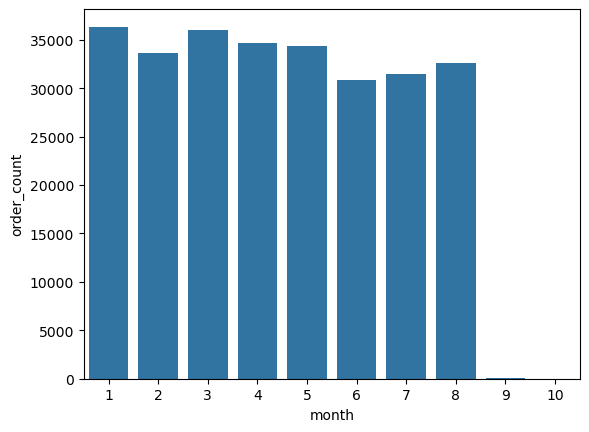

In [54]:
query= """ SELECT month(order_purchase_timestamp), count(month(order_purchase_timestamp)) FROM orders
where year(order_purchase_timestamp)=2018
group by month(order_purchase_timestamp)
order by month(order_purchase_timestamp);
 """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["month","order_count"])
sns.barplot(x=df["month"],y=df["order_count"],data=df)

plt.show()


# Find the average number of products per order, grouped by customer city.

In [9]:
query= """ with count_per_order as  (select o.order_id,o.customer_id, count(oi.order_id) as oc from orders as o join order_items as oi
on oi.order_id=o.order_id
group by o.order_id , o.customer_id)
select c.customer_city , round(avg(count_per_order.oc),2) from customers as c join count_per_order
on c.customer_id=count_per_order.customer_id
group by c.customer_city;
 """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Customer City", "average no. of products per order"])
df

,Customer City,average no. of products per order
0,sao paulo,28.91
1,sao jose dos campos,28.46
2,porto alegre,29.37
3,indaial,27.88
4,treze tilias,31.82
...,...,...
4105,sambaiba,25.00
4106,guairaca,50.00
4107,japaratuba,25.00
4108,tuiuti,25.00


# Calculate the percentage of total revenue contributed by each product category.

In [10]:
query= """ SELECT 
    pr.product_category,
    ROUND(SUM(DISTINCT pa.payment_value) / (SELECT SUM(payment_value) FROM payments) * 100, 2) AS percentage
FROM payments pa
JOIN order_items oi ON pa.order_id = oi.order_id
JOIN products pr ON oi.product_id = pr.product_id
GROUP BY pr.product_category
ORDER BY percentage DESC;
 """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Product Category", "Sales percentage"])
df.head()

,Product Category,Sales percentage
0,HEALTH BEAUTY,1.18
1,Watches present,1.15
2,sport leisure,1.07
3,bed table bath,0.96
4,computer accessories,0.94


#  Identify the correlation between product price and the number of times a product has been purchased.

In [11]:
query= """ SELECT distinct pr.product_category,count(oi.product_id),round(avg(oi.price),2)  FROM 
order_items as oi
    join
    products as pr on pr.product_id=oi.product_id
GROUP BY 
  pr.product_category;
 """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Category", "order count","avg Price"])
arr1=df["order count"]
arr2=df["avg Price"]
np.corrcoef(arr1,arr2)

#correlation value is so close that'why it is neutral no correlation

array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

# Calculate the total revenue generated by each seller, and rank them by revenue.

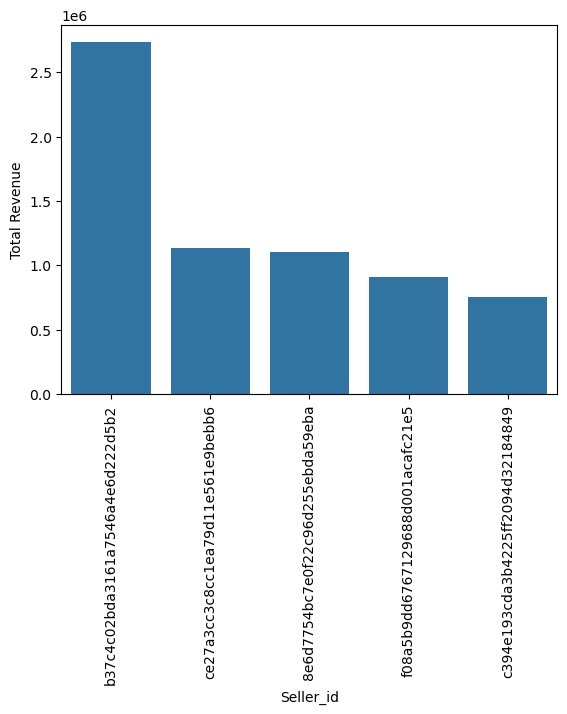

In [12]:
query= """ WITH seller_revenue AS (
    SELECT 
        distinct oi.seller_id,
        sum(p.payment_value) AS total_revenue
    FROM 
        order_items as oi
        join payments as p on oi.order_id=p.order_id
    GROUP BY 
    oi.seller_id, p.payment_value
)
SELECT
    seller_id,
    total_revenue,
    dense_RANK() OVER (ORDER BY total_revenue DESC) AS revenue_rank
FROM
    seller_revenue
ORDER BY
    revenue_rank;
 """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Seller_id", "Total Revenue","Rank"])
df=df.head()
sns.barplot(x="Seller_id", y="Total Revenue", data=df)
plt.xticks(rotation=90)
plt.show()

#  Calculate the moving average of order values for each customer over their order history.

In [16]:
query= """ select customer_id, order_purchase_timestamp, payment,avg(payment) 
over(partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row) as mov_avg from
(SELECT o.customer_id, o.order_purchase_timestamp,p.payment_value as payment 
FROM 
orders as o join payments as p on p.order_id=o.order_id)
as a;"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
2597145,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
2597146,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
2597147,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
2597148,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# Calculate the cumulative sales per month for each year.

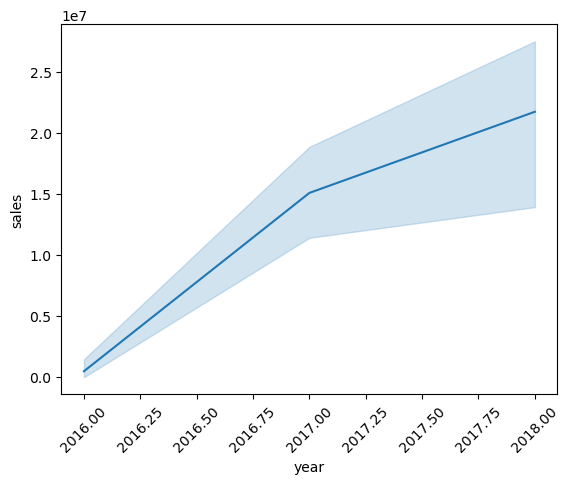

In [27]:
query= """ select year, month,payment,sum(payment) 
over(order by year,month) as cumulative_sales from
(SELECT year(o.order_purchase_timestamp) as year, month(o.order_purchase_timestamp) as month, round(sum(p.payment_value),2) as payment 
FROM payments as p join orders as o on p.order_id=o.order_id
group by year, month
order by year, month) as a
;"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["year","month","sales","cumulative sales"])
sns.lineplot(x="year", y="sales", data=df)
plt.xticks(rotation=45)
plt.show()